# **Production Engineering**

# *Reservoir Inflow Behaviour*

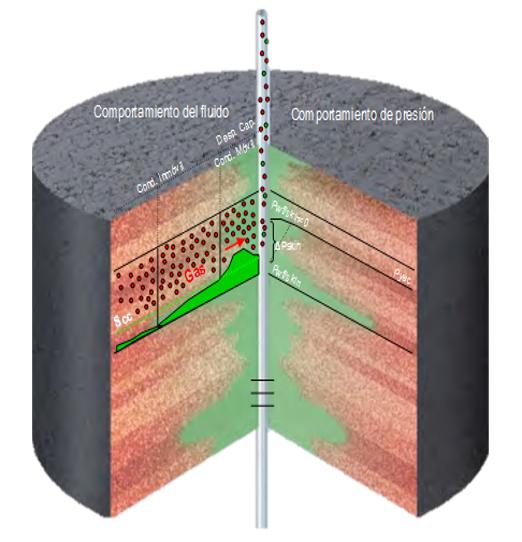

# Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config Completer.use_jedi = False

# **Important Functions**

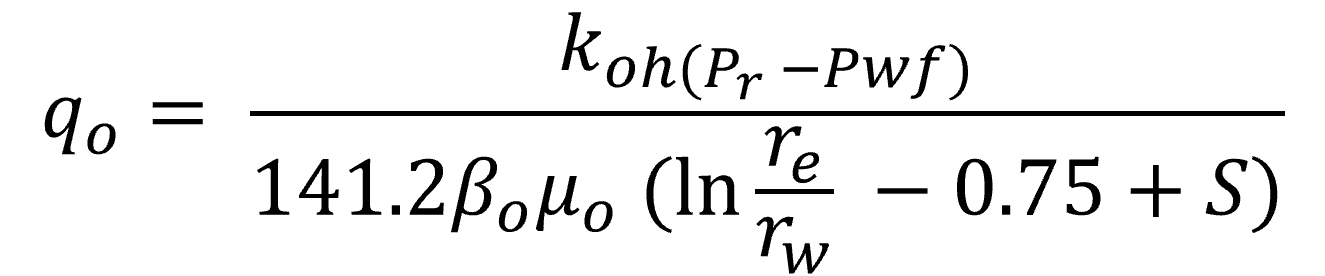

## **Productivity Index Taking into account Petrophysical and Fluid Properties**

$$J=\frac{K_{o}\,h}{141.2\,B_{o}\,u_{o}(\ln{\frac{r_{e}}{r_{w}}}-0.75+s)}$$

**Where:** \
*$J$:* Productivity Index (bpd/psi)\
*$K_{o}$:* Effective permeablity (md)\
*$h$:* Thickness (ft)\
*$B_{o}$:* Oil Formation Volume Factor (rb/stb)\
*$u_{o}$:* Oil Viscosity (cp)\
*$r_{e}$:* Drainage ratio (ft)\
*$r_{w}$:* Well ratio (ft)\
*$s$:* Skin

In [3]:
# Productivity Index (darcy law)
def J_darcy(ko, h, bo, uo, re, rw, s, flow_regime = 'seudocontinuo'):
    if flow_regime == 'seudocontinuo':
        J = ko * h / (141.2 * bo * uo * (np.log(re / rw) - 0.75 + s))
    elif flow_regime == 'continuo':
        J = ko * h / (141.2 * bo * uo * (np.log(re / rw) + s))
    return J

## **Productivity Index with productivity test data**

$$J=\frac{Q_{o}}{P_{r} - Pwf}$$ 

**Where:** \
*$J$:* Productivity Index (bpd/psi)\
*$Q_{o}$:* Oil Flow Rate (bpd)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$Pwf$:* Pressure Well Flowing (psia)

In [4]:
# Productivity Index
def J(q_test, pwf_test, pr, pb):
    if pwf_test > pb:
        J = q_test / (pr - pwf_test)
    else:
        J = q_test / ((pr - pb) + (pb / 1.8) * (1 - 0.2 * (pwf_test / pb) - 0.8 * (pwf_test / pb)**2))    
    return J

## **Oil Flow Rate at Bubble Point**

$$Q_{b}=J(P_{r} - P_{b})$$

**Where:** \
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd) \
*$J$:* Productivity Index (bpd/psi) \
*$P_{r}$:* Reservoir Pressure (psia) \
*$P_{b}$:* Bubble Point Pressue

In [5]:
# Q(bpd) @ Pb 
def Qb(q_test, pwf_test, pr, pb):
    qb = J(q_test, pwf_test, pr, pb) * (pr - pb)
    return qb

## **AOF at different conditions**

**If $P_{r}$ > $P_{b}$** -> The oil reservoir is **UNDERSATURATED:** 

At this case, there are 2 conditions: 

*- If $Pwf$ >= $P_{b}$*: 
$$AOF=JP_{r}$$ 

*Otherwise*, 
$$AOF=Q_{b} + \frac{JP_{b}}{1.8}$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> The oil reservoir is **SATURATED:** 

At this situation:

$$AOF=\frac{Qo_{test}}{1 - 0.2 (\frac{Pwf_{test}}{P_{r}}) - 0.8 (\frac{Pwf_{test}}{P_{r}})^2}$$

**Where:** \
*$AOF$:* Absolute Open Flow (bpd)\
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd)\ 
*$J$:* Productivity Index (bpd/psi)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$P_{b}$:* Bubble Point Pressue\
*$Pwf$:* Pressure Well Flowing (psia)\
*$Pwf_{test}$:* Pressure Well Flowing of productity test (psia)\
*$Qo_{test}$:* Oil Flow Rate of productivity test (bpd)

In [6]:
# AOF(bpd)
def aof(q_test, pwf_test, pr, pb, pwf):
    if pr > pb: # Yac. subsaturado
        if pwf >= pb:
            aof = J(q_test, pwf_test, pr, pb) * pr
        elif pwf <  pb:
            aof = Qb(q_test, pwf_test, pr, pb) + ((J(q_test, pwf_test, pr, pb) * pb) / (1.8))
    else: # Yac. Saturado
        aof = q_test / (1 - 0.2 * (pwf_test / pr) - 0.8 * (pwf_test / pr)**2)
    return aof

## **$Q_{o}$ at Different Conditions**

Here, it is assumed that FE (Flow Efficiency) = 100% by using Vogel's statements.

**If $P_{r}$ > $P_{b}$** -> The oil reservoir is **UNDERSATURATED:** 

At this case, there are 2 conditions: 

*- If $Pwf$ >= $P_{b}$*: 
$$Q_{o}=J(P_{r} - Pwf)$$

*Otherwise*,
$$Q_{o}=Q_{b} + \frac{JP_{b}}{1.8}(1-0.2 (\frac{Pwf}{P_{b}})-0.8 (\frac{Pwf}{P_{b}})^2)$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> The oil reservoir is **SATURATED:** 

At this situation:
$$Q_{o}=AOF(1-0.2 (\frac{Pwf}{P_{b}})-0.8 (\frac{Pwf}{P_{b}})^2)$$

**Where:** \
*$Q_{o}$:* Oil Flow Rate of productivity test (bpd)\
*$AOF$:* Absolute Open Flow (bpd)\
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd)\ 
*$J$:* Productivity Index (bpd/psi)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$P_{b}$:* Bubble Point Pressue\
*$Pwf$:* Pressure Well Flowing (psia)

In [7]:
#Qo(bpd) @ vogel conditions
def qo_vogel(q_test, pwf_test, pr, pwf, pb):
    if pr > pb: # Yac. subsaturado
        if pwf >= pb:
            qo = J(q_test, pwf_test, pr, pb) * (pr - pwf)
        elif pwf < pb: 
            qo =  Qb(q_test, pwf_test, pr, pb) + ((J(q_test, pwf_test, pr, pb) * pb) / (1.8)) * \
            (1 - 0.2 * (pwf / pb) - 0.8 * ( pwf / pb)**2)
    elif pr <= pb: # Yac. Saturado
        qo = aof(q_test, pwf_test, pr, pb, pwf) * (1 - 0.2 * (pwf / pr) - 0.8 * ( pwf / pr)**2)
    return qo

## **Pwf at Different Conditions**

Here, it is assumed that FE (Flow Efficiency) = 100% by using Vogel's statements.

**If $P_{r}$ > $P_{b}$** -> The oil reservoir is **UNDERSATURATED:** 

At this case, there are 2 conditions: 

*- If $Q_{o}$ <= $Q_{b}$*: 
$$Pwf=P_{r} - \frac{Q_{o}}{J}$$

*Otherwise*,
$$Pwf=0.125P_{r}(-1+ \sqrt{81-\frac{80Q_{o}}{Qo_{max}}})$$ ; $$Qo_{max}=Q_{b} + \frac{JP_{b}}{1.8}$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> The oil reservoir is **SATURATED:** 

At this situation:
$$Pwf=0.125P_{r}(-1+ \sqrt{81-\frac{80Q_{o}}{Qo_{max}}})$$ ; $$Qo_{max}=\frac{Qo_{test}}{1 - 0.2 (\frac{Pwf_{test}}{P_{r}}) - 0.8 (\frac{Pwf_{test}}{P_{r}})^2}$$

**Where:** \
*$Q_{o}$:* Oil Flow Rate of productivity test (bpd)\
*$AOF = Qo_{max}$:* Absolute Open Flow (bpd)\
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd)\ 
*$J$:* Productivity Index (bpd/psi)\
*$P_{r}$:* Reservoir Pressure (psia)\
*$P_{b}$:* Bubble Point Pressue\
*$Pwf$:* Pressure Well Flowing (psia)\
*$Pwf_{test}$:* Pressure Well Flowing of productity test (psia)\
*$Qo_{test}$:* Oil Flow Rate of productivity test (bpd)

In [8]:
# Pwf @ vogel conditions
def pwf_vogel(q_test, pwf_test, pr, qo, pb):
    if pr > pb:
        if qo <= Qb(q_test, pwf_test, pr, pb):
            pwf = pr - qo / J(q_test, pwf_test, pr, pb)
        elif qo > Qb(q_test, pwf_test, pr, pb):
            Qmax = Qb(q_test, pwf_test, pr, pb) + ((J(q_test, pwf_test, pr, pb) * pb) / (1.8))
            pwf = 0.125*pr*(-1 + np.sqrt(81 - 80*qo/Qmax))
    elif pr <= pb:
        Qmax = q_test / (1 - 0.2 * (pwf_test / pr) - 0.8 * (pwf_test / pr)**2)
        pwf = 0.125*pr*(-1 + np.sqrt(81 - 80*qo/Qmax))
    return pwf    

## *Ejercicio 1*

In [9]:
# Data
ko = 8.2 #md
h = 53 #ft
bo = 1.2 #rb/stb
uo = 1.2 #cp
re = 2978.4 # ft
rw = 0.328 # ft
s = 0
pr = 5651 #psia

### a) J

In [10]:
J_darcy = J_darcy(ko, h, bo, uo, re, rw, s)
print(f"J -> {J_darcy} bpd/psia")

J -> 0.25555511281513077 bpd/psia


### b) AOF

In [11]:
AOF = J_darcy * pr
print(f"AOF -> {AOF} bpd")

AOF -> 1444.141942518304 bpd


## *Ejercicio 2*

In [12]:
# Data
pr = 2400 #psia
pb = 2500 #psia
pwf = 1000 #psia
q_test = 100 #stb/d
pwf_test = 1800 #psia

### a) AOF

In [13]:
AOF = aof(q_test, pwf_test, pr, pb, pwf)
print(f"AOF -> {AOF} bpd")

AOF -> 250.00000000000003 bpd


### b) IPR Curve

In [14]:
# Creating Dataframe
df = pd.DataFrame()

df['Pwf(psia)'] = np.array([2400, 2000, 1500, 1000, 500, 0])
df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_vogel(q_test, pwf_test, pr, x, pb))

In [15]:
df

,Pwf(psia),Qo(bpd)
0,2400,0.000000
1,2000,69.444444
2,1500,140.625000
3,1000,194.444444
4,500,230.902778
5,0,250.000000


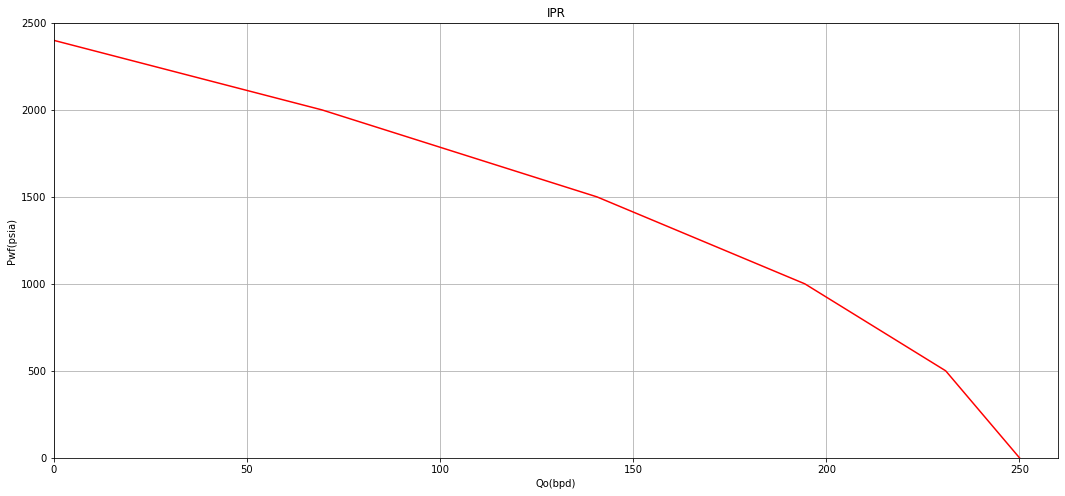

In [16]:
# Plot

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df['Qo(bpd)'], df['Pwf(psia)'], c='red')
ax.set_xlabel('Qo(bpd)')
ax.set_ylabel('Pwf(psia)')
ax.set_title('IPR')
ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'][0] + 100))
ax.grid()
plt.show()

## *Ejercicio 3*

In [17]:
# Data
pr = 120 #bar
pb = 65 #bar
q_test = 400 #m3/d
pwf_test = 100 #bar
pwf = 40 #bar

### Qo @ Pwf=40 bar

## *Ejercicio 4*

In [18]:
# Data
pr = 4000 #psi
pb = 3000 #psi
qo_test = 600 #bpd
pwf_test = 2000 #bpd

### a) Qmax

### b) Qo @ Pwf = 3500 psi

### c) Qo @ Pwf = 1000 psi

### d) pwf @ Q = 1110 bpd

### e) IPR Curve